## Work
### 請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [25]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [26]:
train, test = keras.datasets.cifar10.load_data()

In [27]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [28]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [29]:
"""
建立神經網路，並加入 L1 或 L2
"""
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 dropout layer
"""
from keras.layers import Dropout

"""
建立神經網路，並加入 BN layer
"""

from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], drp_ratio=0.2, l2_ratio=1e-4, bn = True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1), 
                                   kernel_regularizer=l2(l2_ratio))(input_layer)
            x = Dropout(drp_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1),
                                   kernel_regularizer=l2(l2_ratio))(x)
            x = Dropout(drp_ratio)(x)
            if bn:
                x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [30]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4]
DROPOUT_EXP= [0.1, 0.25]
BN = [True, False]

In [31]:
results = {}
"""
使用迴圈建立不同的帶不同 L1/L2 的模型並訓練
"""
for regulizer_ratio, dropout_ratio, bn_flag in itertools.product(L2_EXP, DROPOUT_EXP, BN):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with Regulizer = %.6f, Dropout = %.6f, BN = %s" % (regulizer_ratio, dropout_ratio, ('On' if bn_flag else 'Off')))
    model = build_mlp(input_shape=x_train.shape[1:],drp_ratio= dropout_ratio, l2_ratio=regulizer_ratio, bn = bn_flag)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-l2-%s, drp-%s, BN-%s" % (str(regulizer_ratio), str(dropout_ratio), ('On' if bn_flag else 'Off'))
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with Regulizer = 0.010000, Dropout = 0.100000, BN = On
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_norm

50000/50000 [==============================] - 9s 186us/step - loss: 1.4663 - acc: 0.5292 - val_loss: 1.6226 - val_acc: 0.4745
Epoch 47/50
50000/50000 [==============================] - 8s 168us/step - loss: 1.4678 - acc: 0.5301 - val_loss: 1.6839 - val_acc: 0.4724
Epoch 48/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.4732 - acc: 0.5270 - val_loss: 1.6003 - val_acc: 0.4832
Epoch 49/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.4746 - acc: 0.5277 - val_loss: 1.5786 - val_acc: 0.4917
Epoch 50/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.4668 - acc: 0.5302 - val_loss: 1.6411 - val_acc: 0.4738
Experiment with Regulizer = 0.010000, Dropout = 0.100000, BN = Off
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
__________________________________________________

50000/50000 [==============================] - 7s 144us/step - loss: 1.6815 - acc: 0.4885 - val_loss: 1.6866 - val_acc: 0.4893
Epoch 45/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6797 - acc: 0.4893 - val_loss: 1.6821 - val_acc: 0.4902
Epoch 46/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6758 - acc: 0.4892 - val_loss: 1.6782 - val_acc: 0.4937
Epoch 47/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6714 - acc: 0.4924 - val_loss: 1.6715 - val_acc: 0.4971
Epoch 48/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6690 - acc: 0.4901 - val_loss: 1.6734 - val_acc: 0.4949
Epoch 49/50
50000/50000 [==============================] - 7s 143us/step - loss: 1.6653 - acc: 0.4926 - val_loss: 1.6749 - val_acc: 0.4933
Epoch 50/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6609 - acc: 0.4939 - val_loss: 1.6708 - val_acc: 0.4952
Experiment with Regulizer = 0.010000, D

50000/50000 [==============================] - 10s 195us/step - loss: 1.6723 - acc: 0.4486 - val_loss: 1.6434 - val_acc: 0.4511
Epoch 40/50
50000/50000 [==============================] - 9s 170us/step - loss: 1.6710 - acc: 0.4441 - val_loss: 1.6459 - val_acc: 0.4590
Epoch 41/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.6571 - acc: 0.4524 - val_loss: 1.6653 - val_acc: 0.4509
Epoch 42/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.6685 - acc: 0.4455 - val_loss: 1.6835 - val_acc: 0.4355
Epoch 43/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.6595 - acc: 0.4488 - val_loss: 1.6427 - val_acc: 0.4571
Epoch 44/50
50000/50000 [==============================] - 8s 164us/step - loss: 1.6563 - acc: 0.4477 - val_loss: 1.7522 - val_acc: 0.4142
Epoch 45/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.6780 - acc: 0.4416 - val_loss: 1.6420 - val_acc: 0.4605
Epoch 46/50
50000/50000 [=============

50000/50000 [==============================] - 7s 139us/step - loss: 1.7941 - acc: 0.4453 - val_loss: 1.7539 - val_acc: 0.4636
Epoch 38/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.7851 - acc: 0.4456 - val_loss: 1.7469 - val_acc: 0.4709
Epoch 39/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.7745 - acc: 0.4447 - val_loss: 1.7320 - val_acc: 0.4708
Epoch 40/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.7679 - acc: 0.4474 - val_loss: 1.7297 - val_acc: 0.4720
Epoch 41/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.7606 - acc: 0.4480 - val_loss: 1.7207 - val_acc: 0.4702
Epoch 42/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.7566 - acc: 0.4496 - val_loss: 1.7169 - val_acc: 0.4694
Epoch 43/50
50000/50000 [==============================] - 7s 140us/step - loss: 1.7462 - acc: 0.4512 - val_loss: 1.7098 - val_acc: 0.4743
Epoch 44/50
50000/50000 [==============

50000/50000 [==============================] - 8s 158us/step - loss: 1.3122 - acc: 0.5787 - val_loss: 1.4967 - val_acc: 0.5169
Epoch 33/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.2997 - acc: 0.5816 - val_loss: 1.5446 - val_acc: 0.5021
Epoch 34/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.3020 - acc: 0.5831 - val_loss: 1.5644 - val_acc: 0.4954
Epoch 35/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.2999 - acc: 0.5844 - val_loss: 1.5563 - val_acc: 0.5018
Epoch 36/50
50000/50000 [==============================] - 8s 152us/step - loss: 1.2962 - acc: 0.5834 - val_loss: 1.5213 - val_acc: 0.5095
Epoch 37/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.2857 - acc: 0.5884 - val_loss: 1.5834 - val_acc: 0.4956
Epoch 38/50
50000/50000 [==============================] - 8s 154us/step - loss: 1.2785 - acc: 0.5908 - val_loss: 1.5143 - val_acc: 0.5155
Epoch 39/50
50000/50000 [==============

50000/50000 [==============================] - 7s 139us/step - loss: 1.4204 - acc: 0.5437 - val_loss: 1.4976 - val_acc: 0.5184
Epoch 31/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.4050 - acc: 0.5496 - val_loss: 1.4635 - val_acc: 0.5299
Epoch 32/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.4008 - acc: 0.5508 - val_loss: 1.4606 - val_acc: 0.5292
Epoch 33/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3898 - acc: 0.5547 - val_loss: 1.4537 - val_acc: 0.5317
Epoch 34/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3818 - acc: 0.5557 - val_loss: 1.4489 - val_acc: 0.5342
Epoch 35/50
50000/50000 [==============================] - 7s 139us/step - loss: 1.3735 - acc: 0.5584 - val_loss: 1.4604 - val_acc: 0.5261
Epoch 36/50
50000/50000 [==============================] - 7s 141us/step - loss: 1.3598 - acc: 0.5630 - val_loss: 1.4510 - val_acc: 0.5327
Epoch 37/50
50000/50000 [==============

50000/50000 [==============================] - 8s 157us/step - loss: 1.5717 - acc: 0.4829 - val_loss: 1.5466 - val_acc: 0.4917
Epoch 26/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5704 - acc: 0.4859 - val_loss: 1.5500 - val_acc: 0.4916
Epoch 27/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5599 - acc: 0.4862 - val_loss: 1.5378 - val_acc: 0.4980
Epoch 28/50
50000/50000 [==============================] - 8s 156us/step - loss: 1.5518 - acc: 0.4920 - val_loss: 1.5316 - val_acc: 0.4971
Epoch 29/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5366 - acc: 0.4974 - val_loss: 1.5397 - val_acc: 0.4995
Epoch 30/50
50000/50000 [==============================] - 8s 165us/step - loss: 1.5461 - acc: 0.4928 - val_loss: 1.5156 - val_acc: 0.5072
Epoch 31/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5376 - acc: 0.4957 - val_loss: 1.5546 - val_acc: 0.4884
Epoch 32/50
50000/50000 [==============

50000/50000 [==============================] - 7s 141us/step - loss: 1.6321 - acc: 0.4666 - val_loss: 1.5648 - val_acc: 0.4916
Epoch 24/50
50000/50000 [==============================] - 7s 142us/step - loss: 1.6220 - acc: 0.4723 - val_loss: 1.5640 - val_acc: 0.4915
Epoch 25/50
50000/50000 [==============================] - 7s 145us/step - loss: 1.6139 - acc: 0.4722 - val_loss: 1.5521 - val_acc: 0.4992
Epoch 26/50
50000/50000 [==============================] - 7s 144us/step - loss: 1.6035 - acc: 0.4774 - val_loss: 1.5431 - val_acc: 0.4963
Epoch 27/50
50000/50000 [==============================] - 7s 147us/step - loss: 1.5911 - acc: 0.4827 - val_loss: 1.5326 - val_acc: 0.4992
Epoch 28/50
50000/50000 [==============================] - 8s 153us/step - loss: 1.5835 - acc: 0.4849 - val_loss: 1.5324 - val_acc: 0.5007
Epoch 29/50
50000/50000 [==============================] - 10s 192us/step - loss: 1.5737 - acc: 0.4878 - val_loss: 1.5293 - val_acc: 0.5007
Epoch 30/50
50000/50000 [=============

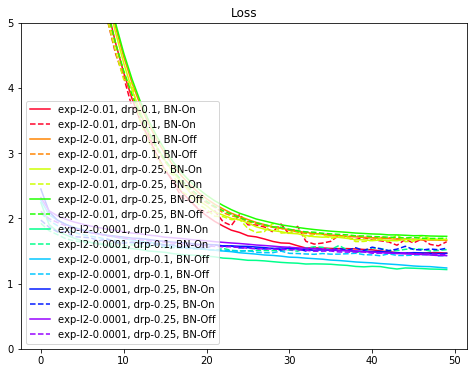

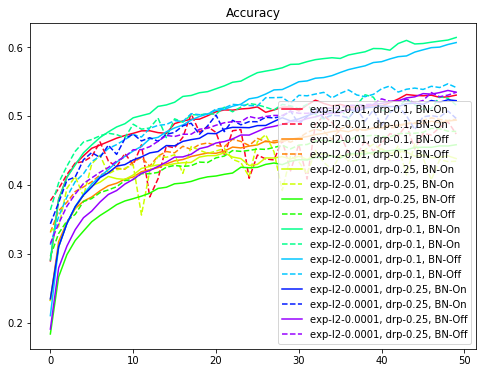

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()